In [1]:
# Importation des bibliothèques nécessaires
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from keras.datasets import cifar10
from keras.layers import Input, Dense,Conv2D,MaxPooling2D,UpSampling2D,BatchNormalization
from keras.models import Model,Sequential
import numpy as np
import pandas as pd
from IPython.display import display, Image


In [17]:
import tensorflow as tf
from keras.callbacks import Callback
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

class CustomMetrics(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        X_val, _ = self.validation_data
        decoded_imgs = self.model.predict(X_val)

        # Calcul du SSIM et du PSNR
        ssim_scores = [ssim(X_val[i], decoded_imgs[i], multichannel=True) for i in range(len(X_val))]
        psnr_scores = [psnr(X_val[i], decoded_imgs[i]) for i in range(len(X_val))]

        # Moyenne des scores
        average_ssim = np.mean(ssim_scores)
        average_psnr = np.mean(psnr_scores)

        # Enregistrement dans les logs
        logs['val_ssim'] = average_ssim
        logs['val_psnr'] = average_psnr

        print(f' - val_ssim: {average_ssim:.4f} - val_psnr: {average_psnr:.4f}')


In [18]:
# Chargement des données CIFAR10
(X_train, _), (X_test, _) = cifar10.load_data()

In [19]:
# Normalisation des données
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

In [20]:
# Redimensionnement des données pour le modèle
X_train = X_train.reshape(len(X_train), X_train.shape[1], X_train.shape[2], 3)
X_test = X_test.reshape(len(X_test), X_test.shape[1], X_test.shape[2], 3)

In [21]:
# Affichage des formes des ensembles de données
print("Forme de l'ensemble d'entraînement:", X_train.shape)
print("Forme de l'ensemble de test:", X_test.shape)

Forme de l'ensemble d'entraînement: (50000, 32, 32, 3)
Forme de l'ensemble de test: (10000, 32, 32, 3)


In [22]:
# Définition de l'architecture de l'autoencodeur
input_img = Input(shape=(32, 32, 3))  # Taille d'entrée pour CIFAR10

In [23]:
# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [24]:
# Construction du modèle
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [25]:
# Résumé du modèle
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 16)        4624      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 16)          2320

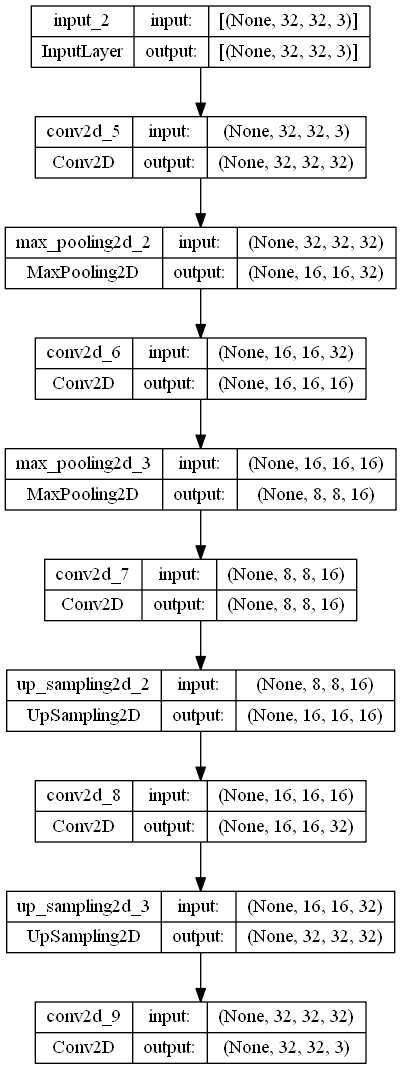

In [27]:
from keras.utils.vis_utils import plot_model
from IPython.display import display, Image

# Création d'une image PNG du modèle
plot_model(autoencoder, to_file='model.png', show_shapes=True, show_layer_names=True)

# Affichage de l'image dans le notebook
display(Image(filename='model.png'))

In [26]:
# Création de l'instance de callback
metrics_callback = CustomMetrics(validation_data=(X_test, X_test))

# Entraînement de l'autoencodeur
history= autoencoder.fit(X_train, X_train,  # Les données cibles sont les mêmes que les entrées
                epochs=5,         # Nombre d'époques pour l'entraînement
                batch_size=256,    # Taille du lot pour l'entraînement
                shuffle=True,      # Mélange aléatoire des données à chaque époque
                validation_data=(X_test, X_test),callbacks=[metrics_callback])  # Utilisation des données de test pour la validation


Epoch 1/5
313/313 [==============================] - 4s 13ms/step
 - val_ssim: 0.7196 - val_psnr: 20.6726
196/196 [==============================] - 100s 506ms/step - loss: 0.5940 - val_loss: 0.5733 - val_ssim: 0.7196 - val_psnr: 20.6726
Epoch 2/5
313/313 [==============================] - 4s 13ms/step
 - val_ssim: 0.7655 - val_psnr: 21.5916
196/196 [==============================] - 94s 479ms/step - loss: 0.5692 - val_loss: 0.5681 - val_ssim: 0.7655 - val_psnr: 21.5916
Epoch 3/5
313/313 [==============================] - 4s 13ms/step
 - val_ssim: 0.7855 - val_psnr: 22.1752
196/196 [==============================] - 92s 470ms/step - loss: 0.5661 - val_loss: 0.5657 - val_ssim: 0.7855 - val_psnr: 22.1752
Epoch 4/5
313/313 [==============================] - 4s 12ms/step
 - val_ssim: 0.8001 - val_psnr: 22.5450
196/196 [==============================] - 93s 475ms/step - loss: 0.5643 - val_loss: 0.5643 - val_ssim: 0.8001 - val_psnr: 22.5450
Epoch 5/5
313/313 [==============================] 

In [28]:
# Prédiction sur l'ensemble de test
decoded_imgs = autoencoder.predict(X_test)

313/313 [==============================] - 4s 11ms/step


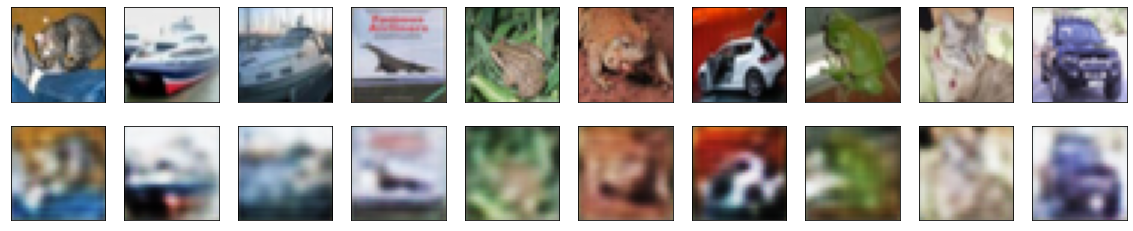

In [29]:
n = 10  # Nombre d'images à afficher
plt.figure(figsize=(20, 4))
for i in range(n):
    # Affichage des images originales
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Affichage des images reconstruites
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [31]:
# Évaluation de la performance de l'autoencodeur
from sklearn.metrics import mean_squared_error

# Calcul de l'erreur quadratique moyenne (MSE) sur l'ensemble de test
mse = mean_squared_error(X_test.flatten(), decoded_imgs.flatten())
print("Erreur quadratique moyenne (MSE) sur l'ensemble de test:", mse)


Erreur quadratique moyenne (MSE) sur l'ensemble de test: 0.0066504967


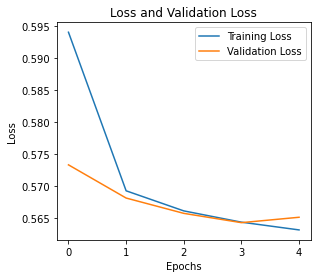

In [32]:
# Tracer la perte et la perte de validation
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [33]:
from skimage.metrics import structural_similarity as ssim

# Calcul du SSIM pour chaque image de l'ensemble de test
ssim_scores = [ssim(X_test[i], decoded_imgs[i], multichannel=True) for i in range(len(X_test))]

# Calcul de la moyenne des scores SSIM
average_ssim = np.mean(ssim_scores)
print("SSIM moyen sur l'ensemble de test:", average_ssim)

SSIM moyen sur l'ensemble de test: 0.8084766469675918


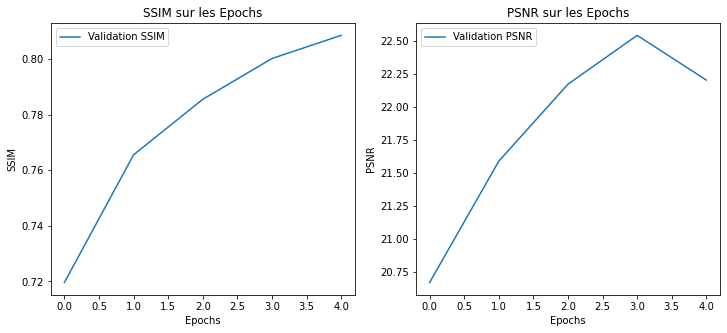

In [34]:
# Tracer SSIM et PSNR
plt.figure(figsize=(12, 5))

# Tracer SSIM
plt.subplot(1, 2, 1)
plt.plot(history.history['val_ssim'], label='Validation SSIM')
plt.title('SSIM sur les Epochs')
plt.xlabel('Epochs')
plt.ylabel('SSIM')
plt.legend()

# Tracer PSNR
plt.subplot(1, 2, 2)
plt.plot(history.history['val_psnr'], label='Validation PSNR')
plt.title('PSNR sur les Epochs')
plt.xlabel('Epochs')
plt.ylabel('PSNR')
plt.legend()

plt.show()